# Patch proximity analysis clean notebook

### Functions

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import matplotlib.colors as mcolors
from concave_hull import concave_hull, concave_hull_indexes

In [35]:
# Function for patch identification
## Adjust clustering parameter to get the desired number of clusters
def apply_dbscan_clustering(df, eps=70, min_samples=10):
    """
    Apply DBSCAN clustering to a dataframe and update the cluster labels in the original dataframe.
    
    Args:
    df (pandas.DataFrame): The dataframe to be clustered.
    eps (float): The maximum distance between two samples for them to be considered as in the same neighborhood.
    min_samples (int): The number of samples in a neighborhood for a point to be considered as a core point.
    
    Returns:
    None
    """
    # Initialize a new column for cluster labels
    df['cluster'] = -1

    # Apply DBSCAN clustering
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(df[['x', 'y']])

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print("Estimated number of clusters: %d" % n_clusters_)
    print("Estimated number of noise points: %d" % n_noise_)

    # Update the cluster labels in the original dataframe
    df.loc[df.index, 'cluster'] = labels
    
# plot points and identify points in radius of selected points
def plot_selected_neighbors_with_shapes(full_df, selected_df, target_df, radius, plot=True, identification_column='community'):
    # Get a list of unique colors for each cluster in full_df
    unique_clusters = full_df[identification_column].unique()
    colors = list(mcolors.TABLEAU_COLORS.values())
    
    # Plot each cluster from full_df
    #if plot:
    #    for cluster in unique_clusters:
    #        subset = full_df[full_df["cluster"] == cluster]
    #        plt.scatter(subset['x'], subset['y'], label=f'{"cluster"} {cluster}', color=colors[cluster])
    
    # Creating a dataframe for points that are within the circle of selected points but belong to a different cluster
    all_in_circle_diff_cluster = pd.DataFrame()
    
    # Highlight points in the circle but from a different cluster
    for _, row in selected_df.iterrows():
        distances = np.linalg.norm(target_df[['x', 'y']].values - np.array([row['x'], row['y']]), axis=1)
        in_circle = distances <= radius
        diff_cluster = target_df[identification_column] != row[identification_column]
        
        # Get indices of points that are in the circle and from a different cluster
        in_circle_diff_cluster = target_df[in_circle & diff_cluster]
        
        # Append to the final dataframe
        all_in_circle_diff_cluster = all_in_circle_diff_cluster.append(in_circle_diff_cluster)
        
        if plot:
            # Plot these points with a different shape
            plt.scatter(in_circle_diff_cluster['x'], in_circle_diff_cluster['y'], 
                        facecolors='none', edgecolors="red", marker='*', s=100, zorder=5, label='Different Cluster in Circle')
    
    if plot:
        # Plot selected points in red
        plt.scatter(selected_df['x'], selected_df['y'], color='yellow', label='Selected Points', s=100, edgecolor='black', zorder=6)
        
        # Draw a circle around each selected point
        for _, row in selected_df.iterrows():
            circle = plt.Circle((row['x'], row['y']), radius, color='red', fill=False, linestyle='--', alpha=0.5)
            plt.gca().add_patch(circle)
        
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title(f'Points with Radius {radius} for Selected Points')
        plt.grid(True)
        plt.axis('equal')
        
        # Place the legend outside the plot
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))  # Remove duplicate labels
        plt.legend(by_label.values(), by_label.keys(), loc='center left', bbox_to_anchor=(1, 0.5))
        plt.tight_layout()
        plt.show()
        
    # Removing duplicates, if any
    all_in_circle_diff_cluster = all_in_circle_diff_cluster.drop_duplicates()

    return all_in_circle_diff_cluster

# generate a dataframe with the points in proximity to the selected points
## points are selected based on the coordinates of a 2D concave hull
### set edge_neighbours to 3 to select the 3 nearest points to the hull or 1 to disable functionality
def identify_points_in_proximity(df, full_df, identification_column, cluster_column = "cluster", x_column='x', y_column='y', radius = 200, edge_neighbours = 3, plot = True, concave_hull_length_threshold = 50):
    # for loop through cluster labels, ignore noise
    
    # genrate empty dataframe to store points in proximity
    result = pd.DataFrame()
    
    for cluster in set(df[cluster_column]) - {-1}: 
        # filter df for cluster
        subset = df[df[cluster_column] == cluster]
        # draw a concave hull around the points
        
        points = subset[[x_column, y_column]].values
        
        idxes = concave_hull_indexes(
            points[:, :2],
            length_threshold=concave_hull_length_threshold,
        )
        
        # identify the points that construct the hull
        hull_points = pd.DataFrame(points[idxes], columns=['x', 'y'])

        # select hull points nearest neighbors in the original dataframe
        nbrs = NearestNeighbors(n_neighbors = edge_neighbours).fit(df[[x_column, y_column]])
        distances, indices = nbrs.kneighbors(hull_points[["x", 'y']])
        hull_nearest_neighbors = df.iloc[indices.flatten()]
        
        # Plotting using the full dataframe and selected points dataframe with external legend
        prox_points = plot_selected_neighbors_with_shapes(full_df= df, selected_df= hull_nearest_neighbors, target_df = full_df, radius= radius, plot = plot, identification_column = identification_column)
        
        # add a unique ID to prox_points
        prox_points['patch_id'] = cluster
        
        # append to the final dataframe
        result = result.append(prox_points)

    return result
    

In [36]:
# read csv file
HubMap = pd.read_csv('/Volumes/Tim_Extern/NolanLab_Datasets/CODEX_HuBMAP_alldata_Dryad.csv')

In [37]:
HubMap["unique_region"].unique()

# filter for unique region = B009_Right
HubMap_B009_Right = HubMap[HubMap["unique_region"] == "B009_Right"]

In [38]:
HubMap_B009_Right["Community"].unique()

array(['Secretory Epithelial', 'Plasma Cell Enriched', 'Follicle',
       'Adaptive Immune Enriched', 'CD8+ T Enriched IEL',
       'CD66+ Mature Epithelial', 'Innate Immune Enriched',
       'Mature Epithelial', 'Smooth Muscle', 'Stroma'], dtype=object)

In [39]:
HubMap_B009_Right_Secretory_Epithelial = HubMap_B009_Right[HubMap_B009_Right["Community"] == "Secretory Epithelial"]

In [40]:
apply_dbscan_clustering(HubMap_B009_Right_Secretory_Epithelial, eps=250, min_samples=80)
HubMap_B009_Right_Secretory_Epithelial["cluster"].value_counts()

Estimated number of clusters: 15
Estimated number of noise points: 631


/var/folders/6d/0x48qjh15rx9851lpdwvrxvc0000gn/T/ipykernel_26170/802723055.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster'] = -1
/var/folders/6d/0x48qjh15rx9851lpdwvrxvc0000gn/T/ipykernel_26170/802723055.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df.index, 'cluster'] = labels


 1     2941
 0     2549
 3      731
 8      671
-1      631
 12     449
 10     375
 5      337
 4      270
 7      211
 11     203
 2      197
 13     169
 6      141
 9      134
 14      81
Name: cluster, dtype: int64

<AxesSubplot: xlabel='x', ylabel='y'>

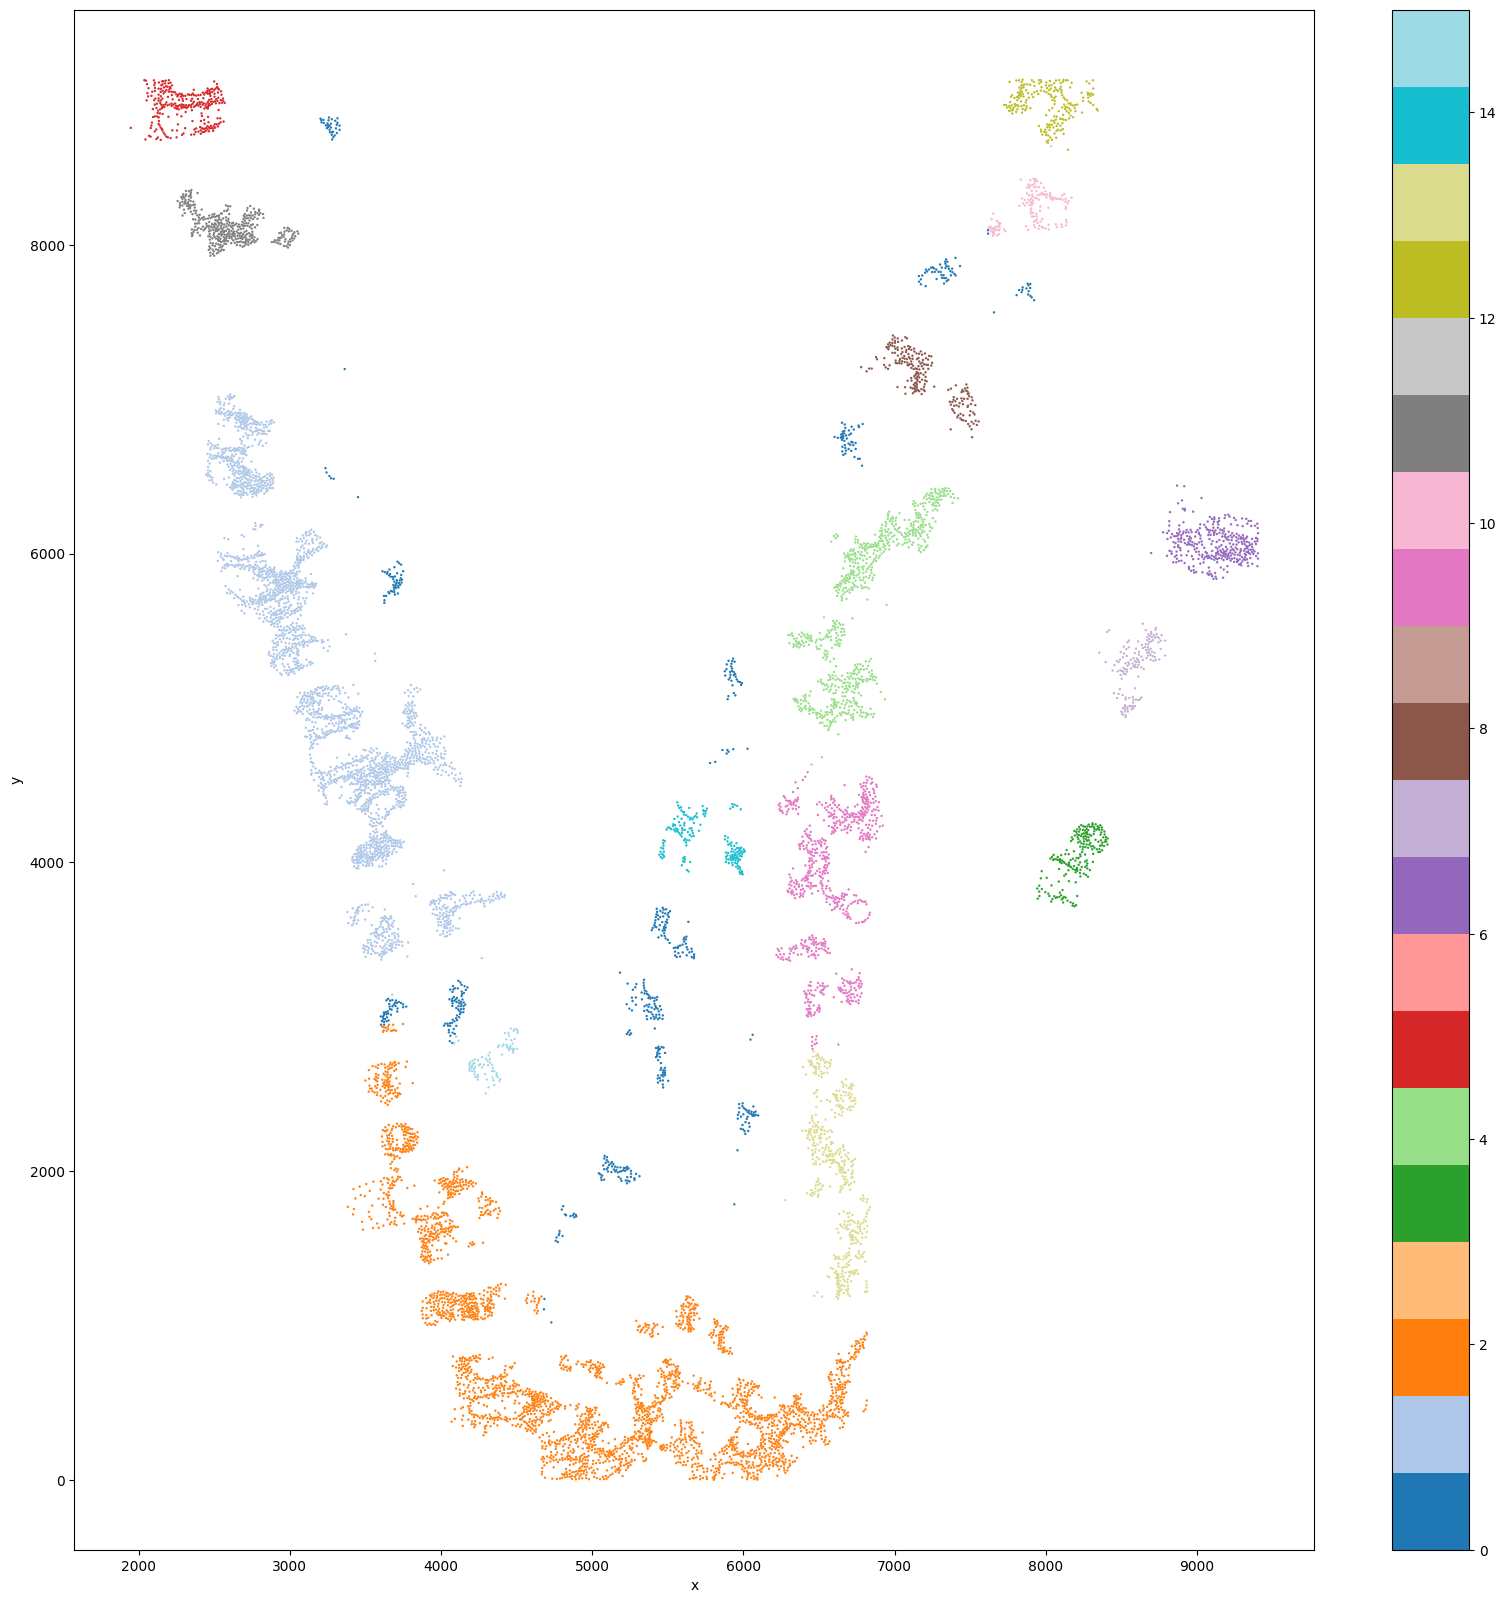

In [41]:
HubMap_B009_Right_Secretory_Epithelial.plot.scatter(x='x', y='y', c=HubMap_B009_Right_Secretory_Epithelial['cluster'].astype('category').cat.codes, cmap='tab20', figsize=(20,20), s=0.5)


/var/folders/6d/0x48qjh15rx9851lpdwvrxvc0000gn/T/ipykernel_26170/802723055.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_in_circle_diff_cluster = all_in_circle_diff_cluster.append(in_circle_diff_cluster)
/var/folders/6d/0x48qjh15rx9851lpdwvrxvc0000gn/T/ipykernel_26170/802723055.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_in_circle_diff_cluster = all_in_circle_diff_cluster.append(in_circle_diff_cluster)
/var/folders/6d/0x48qjh15rx9851lpdwvrxvc0000gn/T/ipykernel_26170/802723055.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_in_circle_diff_cluster = all_in_circle_diff_cluster.append(in_circle_diff_cluster)
/var/folders/6d/0x48qjh15rx9851lpdwvrxvc0000gn/T/ipykernel_26170/802723055.py:57: Future

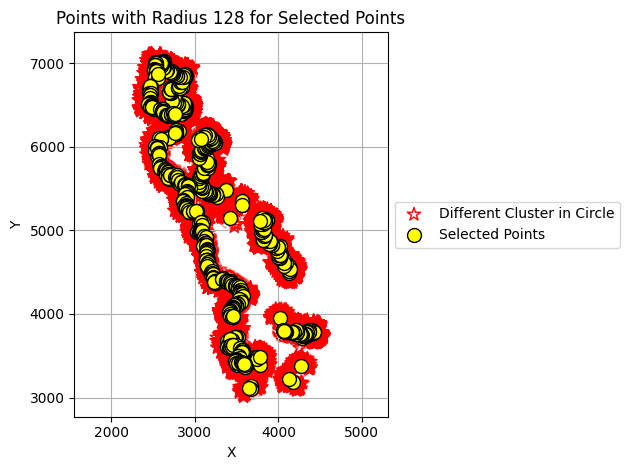

/var/folders/6d/0x48qjh15rx9851lpdwvrxvc0000gn/T/ipykernel_26170/802723055.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append(prox_points)
/var/folders/6d/0x48qjh15rx9851lpdwvrxvc0000gn/T/ipykernel_26170/802723055.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_in_circle_diff_cluster = all_in_circle_diff_cluster.append(in_circle_diff_cluster)
/var/folders/6d/0x48qjh15rx9851lpdwvrxvc0000gn/T/ipykernel_26170/802723055.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_in_circle_diff_cluster = all_in_circle_diff_cluster.append(in_circle_diff_cluster)
/var/folders/6d/0x48qjh15rx9851lpdwvrxvc0000gn/T/ipykernel_26170/802723055.py:57: FutureWarning: The frame.append method is deprecated and

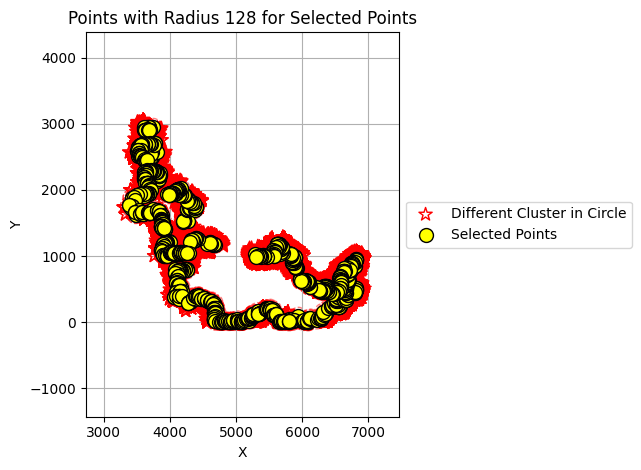

/var/folders/6d/0x48qjh15rx9851lpdwvrxvc0000gn/T/ipykernel_26170/802723055.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append(prox_points)
/var/folders/6d/0x48qjh15rx9851lpdwvrxvc0000gn/T/ipykernel_26170/802723055.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_in_circle_diff_cluster = all_in_circle_diff_cluster.append(in_circle_diff_cluster)
/var/folders/6d/0x48qjh15rx9851lpdwvrxvc0000gn/T/ipykernel_26170/802723055.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_in_circle_diff_cluster = all_in_circle_diff_cluster.append(in_circle_diff_cluster)
/var/folders/6d/0x48qjh15rx9851lpdwvrxvc0000gn/T/ipykernel_26170/802723055.py:57: FutureWarning: The frame.append method is deprecated and

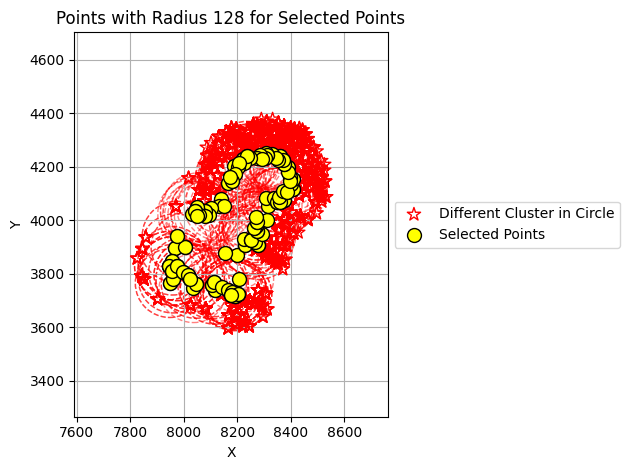

/var/folders/6d/0x48qjh15rx9851lpdwvrxvc0000gn/T/ipykernel_26170/802723055.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append(prox_points)
/var/folders/6d/0x48qjh15rx9851lpdwvrxvc0000gn/T/ipykernel_26170/802723055.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_in_circle_diff_cluster = all_in_circle_diff_cluster.append(in_circle_diff_cluster)
/var/folders/6d/0x48qjh15rx9851lpdwvrxvc0000gn/T/ipykernel_26170/802723055.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_in_circle_diff_cluster = all_in_circle_diff_cluster.append(in_circle_diff_cluster)
/var/folders/6d/0x48qjh15rx9851lpdwvrxvc0000gn/T/ipykernel_26170/802723055.py:57: FutureWarning: The frame.append method is deprecated and

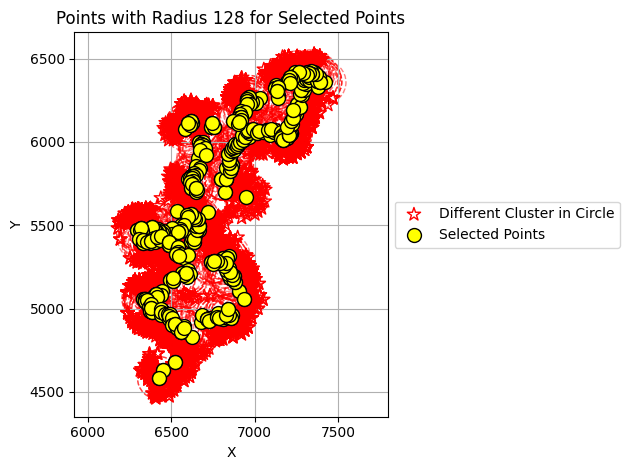

/var/folders/6d/0x48qjh15rx9851lpdwvrxvc0000gn/T/ipykernel_26170/802723055.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append(prox_points)
/var/folders/6d/0x48qjh15rx9851lpdwvrxvc0000gn/T/ipykernel_26170/802723055.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_in_circle_diff_cluster = all_in_circle_diff_cluster.append(in_circle_diff_cluster)
/var/folders/6d/0x48qjh15rx9851lpdwvrxvc0000gn/T/ipykernel_26170/802723055.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_in_circle_diff_cluster = all_in_circle_diff_cluster.append(in_circle_diff_cluster)
/var/folders/6d/0x48qjh15rx9851lpdwvrxvc0000gn/T/ipykernel_26170/802723055.py:57: FutureWarning: The frame.append method is deprecated and

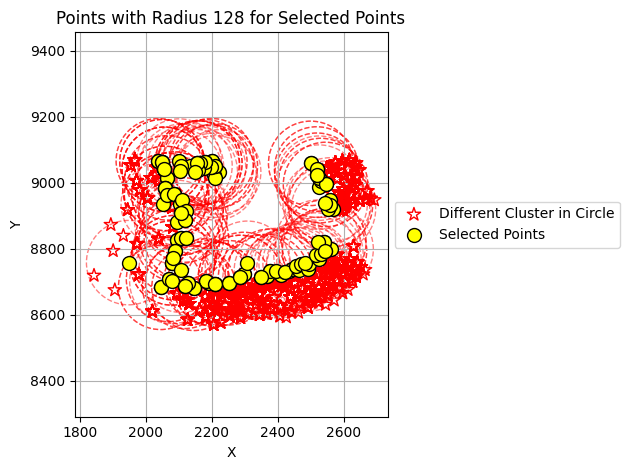

/var/folders/6d/0x48qjh15rx9851lpdwvrxvc0000gn/T/ipykernel_26170/802723055.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append(prox_points)
/var/folders/6d/0x48qjh15rx9851lpdwvrxvc0000gn/T/ipykernel_26170/802723055.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_in_circle_diff_cluster = all_in_circle_diff_cluster.append(in_circle_diff_cluster)
/var/folders/6d/0x48qjh15rx9851lpdwvrxvc0000gn/T/ipykernel_26170/802723055.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_in_circle_diff_cluster = all_in_circle_diff_cluster.append(in_circle_diff_cluster)
/var/folders/6d/0x48qjh15rx9851lpdwvrxvc0000gn/T/ipykernel_26170/802723055.py:57: FutureWarning: The frame.append method is deprecated and

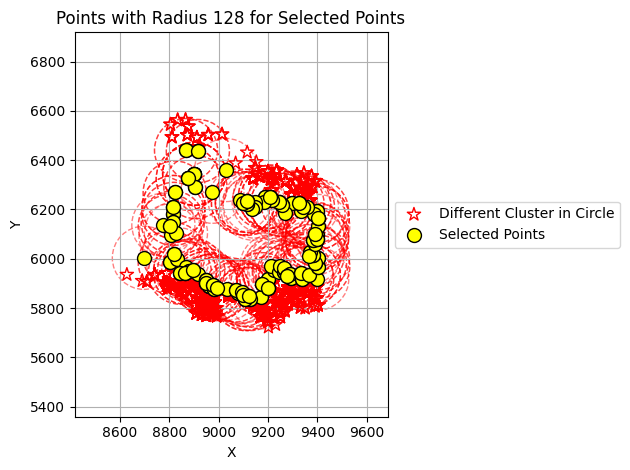

/var/folders/6d/0x48qjh15rx9851lpdwvrxvc0000gn/T/ipykernel_26170/802723055.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append(prox_points)
/var/folders/6d/0x48qjh15rx9851lpdwvrxvc0000gn/T/ipykernel_26170/802723055.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_in_circle_diff_cluster = all_in_circle_diff_cluster.append(in_circle_diff_cluster)
/var/folders/6d/0x48qjh15rx9851lpdwvrxvc0000gn/T/ipykernel_26170/802723055.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_in_circle_diff_cluster = all_in_circle_diff_cluster.append(in_circle_diff_cluster)
/var/folders/6d/0x48qjh15rx9851lpdwvrxvc0000gn/T/ipykernel_26170/802723055.py:57: FutureWarning: The frame.append method is deprecated and

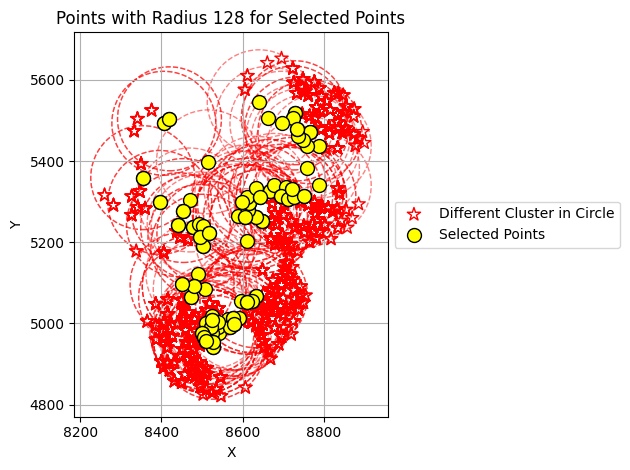

/var/folders/6d/0x48qjh15rx9851lpdwvrxvc0000gn/T/ipykernel_26170/802723055.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append(prox_points)
/var/folders/6d/0x48qjh15rx9851lpdwvrxvc0000gn/T/ipykernel_26170/802723055.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_in_circle_diff_cluster = all_in_circle_diff_cluster.append(in_circle_diff_cluster)
/var/folders/6d/0x48qjh15rx9851lpdwvrxvc0000gn/T/ipykernel_26170/802723055.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_in_circle_diff_cluster = all_in_circle_diff_cluster.append(in_circle_diff_cluster)
/var/folders/6d/0x48qjh15rx9851lpdwvrxvc0000gn/T/ipykernel_26170/802723055.py:57: FutureWarning: The frame.append method is deprecated and

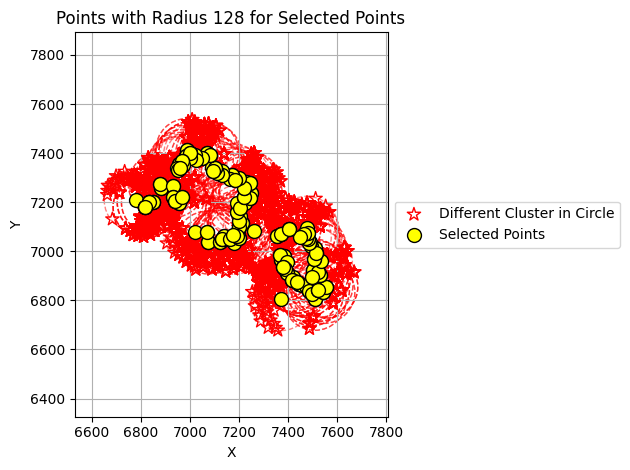

/var/folders/6d/0x48qjh15rx9851lpdwvrxvc0000gn/T/ipykernel_26170/802723055.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append(prox_points)
/var/folders/6d/0x48qjh15rx9851lpdwvrxvc0000gn/T/ipykernel_26170/802723055.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_in_circle_diff_cluster = all_in_circle_diff_cluster.append(in_circle_diff_cluster)
/var/folders/6d/0x48qjh15rx9851lpdwvrxvc0000gn/T/ipykernel_26170/802723055.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_in_circle_diff_cluster = all_in_circle_diff_cluster.append(in_circle_diff_cluster)
/var/folders/6d/0x48qjh15rx9851lpdwvrxvc0000gn/T/ipykernel_26170/802723055.py:57: FutureWarning: The frame.append method is deprecated and

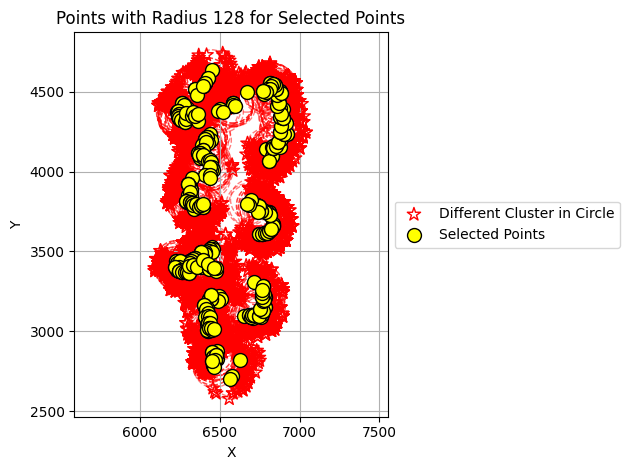

/var/folders/6d/0x48qjh15rx9851lpdwvrxvc0000gn/T/ipykernel_26170/802723055.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append(prox_points)
/var/folders/6d/0x48qjh15rx9851lpdwvrxvc0000gn/T/ipykernel_26170/802723055.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_in_circle_diff_cluster = all_in_circle_diff_cluster.append(in_circle_diff_cluster)
/var/folders/6d/0x48qjh15rx9851lpdwvrxvc0000gn/T/ipykernel_26170/802723055.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_in_circle_diff_cluster = all_in_circle_diff_cluster.append(in_circle_diff_cluster)
/var/folders/6d/0x48qjh15rx9851lpdwvrxvc0000gn/T/ipykernel_26170/802723055.py:57: FutureWarning: The frame.append method is deprecated and

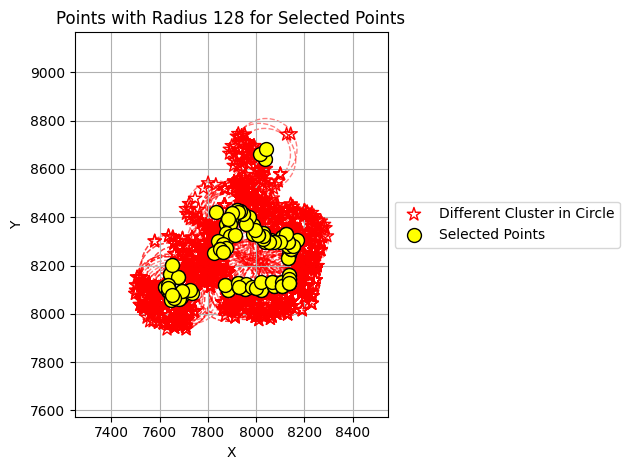

/var/folders/6d/0x48qjh15rx9851lpdwvrxvc0000gn/T/ipykernel_26170/802723055.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append(prox_points)
/var/folders/6d/0x48qjh15rx9851lpdwvrxvc0000gn/T/ipykernel_26170/802723055.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_in_circle_diff_cluster = all_in_circle_diff_cluster.append(in_circle_diff_cluster)
/var/folders/6d/0x48qjh15rx9851lpdwvrxvc0000gn/T/ipykernel_26170/802723055.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_in_circle_diff_cluster = all_in_circle_diff_cluster.append(in_circle_diff_cluster)
/var/folders/6d/0x48qjh15rx9851lpdwvrxvc0000gn/T/ipykernel_26170/802723055.py:57: FutureWarning: The frame.append method is deprecated and

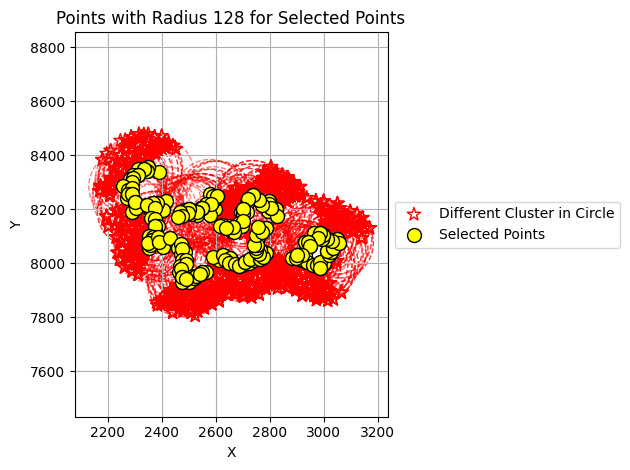

/var/folders/6d/0x48qjh15rx9851lpdwvrxvc0000gn/T/ipykernel_26170/802723055.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append(prox_points)
/var/folders/6d/0x48qjh15rx9851lpdwvrxvc0000gn/T/ipykernel_26170/802723055.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_in_circle_diff_cluster = all_in_circle_diff_cluster.append(in_circle_diff_cluster)
/var/folders/6d/0x48qjh15rx9851lpdwvrxvc0000gn/T/ipykernel_26170/802723055.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_in_circle_diff_cluster = all_in_circle_diff_cluster.append(in_circle_diff_cluster)
/var/folders/6d/0x48qjh15rx9851lpdwvrxvc0000gn/T/ipykernel_26170/802723055.py:57: FutureWarning: The frame.append method is deprecated and

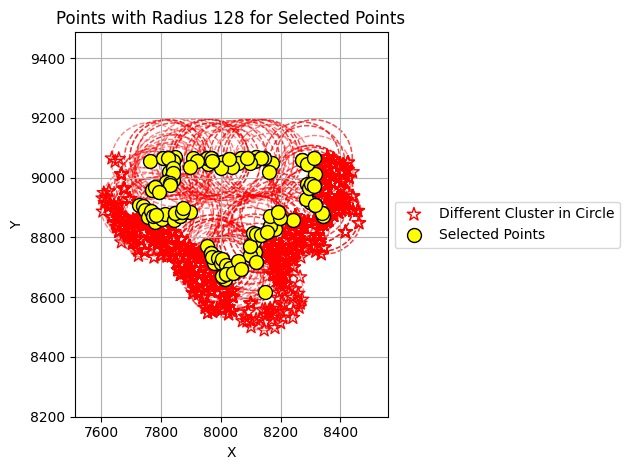

/var/folders/6d/0x48qjh15rx9851lpdwvrxvc0000gn/T/ipykernel_26170/802723055.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append(prox_points)
/var/folders/6d/0x48qjh15rx9851lpdwvrxvc0000gn/T/ipykernel_26170/802723055.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_in_circle_diff_cluster = all_in_circle_diff_cluster.append(in_circle_diff_cluster)
/var/folders/6d/0x48qjh15rx9851lpdwvrxvc0000gn/T/ipykernel_26170/802723055.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_in_circle_diff_cluster = all_in_circle_diff_cluster.append(in_circle_diff_cluster)
/var/folders/6d/0x48qjh15rx9851lpdwvrxvc0000gn/T/ipykernel_26170/802723055.py:57: FutureWarning: The frame.append method is deprecated and

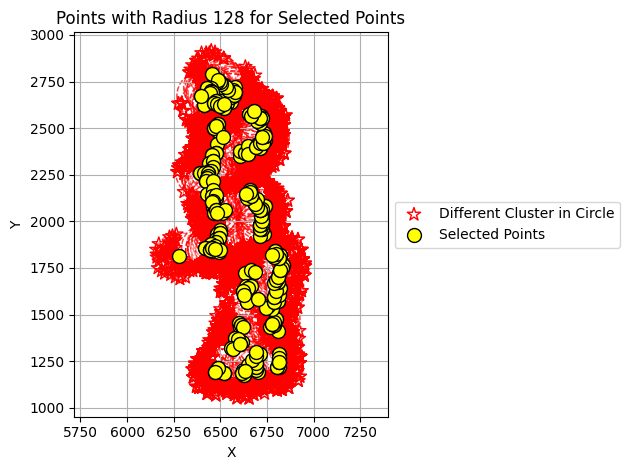

/var/folders/6d/0x48qjh15rx9851lpdwvrxvc0000gn/T/ipykernel_26170/802723055.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append(prox_points)
/var/folders/6d/0x48qjh15rx9851lpdwvrxvc0000gn/T/ipykernel_26170/802723055.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_in_circle_diff_cluster = all_in_circle_diff_cluster.append(in_circle_diff_cluster)
/var/folders/6d/0x48qjh15rx9851lpdwvrxvc0000gn/T/ipykernel_26170/802723055.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_in_circle_diff_cluster = all_in_circle_diff_cluster.append(in_circle_diff_cluster)
/var/folders/6d/0x48qjh15rx9851lpdwvrxvc0000gn/T/ipykernel_26170/802723055.py:57: FutureWarning: The frame.append method is deprecated and

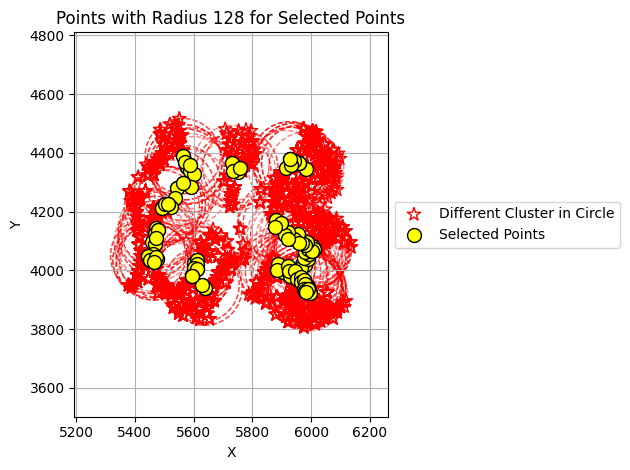

/var/folders/6d/0x48qjh15rx9851lpdwvrxvc0000gn/T/ipykernel_26170/802723055.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append(prox_points)
/var/folders/6d/0x48qjh15rx9851lpdwvrxvc0000gn/T/ipykernel_26170/802723055.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_in_circle_diff_cluster = all_in_circle_diff_cluster.append(in_circle_diff_cluster)
/var/folders/6d/0x48qjh15rx9851lpdwvrxvc0000gn/T/ipykernel_26170/802723055.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_in_circle_diff_cluster = all_in_circle_diff_cluster.append(in_circle_diff_cluster)
/var/folders/6d/0x48qjh15rx9851lpdwvrxvc0000gn/T/ipykernel_26170/802723055.py:57: FutureWarning: The frame.append method is deprecated and

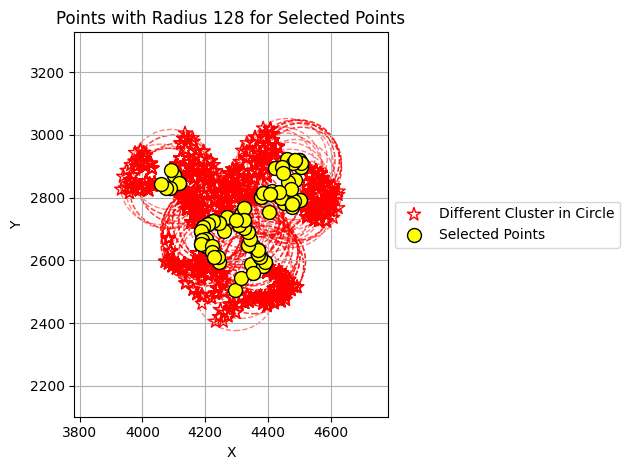

/var/folders/6d/0x48qjh15rx9851lpdwvrxvc0000gn/T/ipykernel_26170/802723055.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append(prox_points)


In [42]:
results = identify_points_in_proximity(df = HubMap_B009_Right_Secretory_Epithelial, full_df= HubMap_B009_Right, cluster_column = "cluster", identification_column = "Community", x_column='x', y_column='y', radius = 128,edge_neighbours = 3, plot = True)